### Import

In [1]:
import os
import random
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import plotly.express as px

import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import (BinaryEncoder,
                                JamesSteinEncoder, 
                                TargetEncoder,
                                BackwardDifferenceEncoder,
                                LeaveOneOutEncoder,
                                MEstimateEncoder,
                                HelmertEncoder,
                                CatBoostEncoder, 
                                CountEncoder, 
                                HashingEncoder)
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer   
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import seaborn as sns
import optuna
# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns

plt.rc('font', family = 'malgun Gothic')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import plotly.express as px

import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier

c:\Users\thoma\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\thoma\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# 동일한 결과 보장을 위해 Seed값을 고정합니다
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed를 42로 고정

In [3]:
# 제공된 train 데이터와 test 데이터를 불러옵니다
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

- 시간 순으로 나열된 7일 동안의 웹 광고 클릭 로그
- ID: train 데이터 샘플 고유 ID
- Click: 예측 목표인 클릭 여부
- 0: 클릭하지 않음, 1: 클릭
- F01 ~ F39 : 각 클릭 로그와 연관된 Feature
- 개인정보 보호를 위해 상세 정보는 비식별 처리됨

### EDA 1 : Sparse and Dense

In [4]:
train.head()

,ID,Click,F01,F02,F03,F04,F05,F06,F07,F08,...,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39
0,TRAIN_00000000,1,NSLHFNS,AVKQTCL,DTZFPRW,114.0,ISVXFVA,1,PQZBVMG,LPYPUNA,...,NZGEZLW,GTISJWW,380.0,2.0,AXQFZWC,IRUDRFB,NaN,TFJMLCZ,0.0,AURZYDY
1,TRAIN_00000001,0,VGIVWZQ,LSUSMVO,PQGWFJZ,26.0,NFRVLWS,43,IMPIGJT,MIGYEEG,...,NZGEZLW,GTISJWW,466.0,1.0,DRVVDHZ,IRUDRFB,19.0,AUGTURV,0.0,LUZRMLU
2,TRAIN_00000002,0,JCDXFYU,PILDDJU,IAGJDOH,119.0,LFPUEOV,0,FFUTIRZ,OFKQGTY,...,VHXETCF,KHZNEZF,197.0,0.0,QMOULXS,IRUDRFB,8.0,ZVSTLNM,0.0,MHBRSQK
3,TRAIN_00000003,1,PSMFWTP,ZYAVJHP,NaN,15.0,ATQPZSJ,26,ZDTZNSB,THBWWCD,...,IVIRTPR,GTISJWW,8640.0,0.0,IZLJUJS,IRUDRFB,14.0,ZBSRLCQ,0.0,GAZBSSZ
4,TRAIN_00000004,0,SLCRICD,QPQWGXA,NaN,13.0,CHZGJZR,20,PQZBVMG,MIGYEEG,...,NZGEZLW,WHSRKIM,41774.0,0.0,BHBIZCL,IRUDRFB,13.0,QHYLSBX,0.0,QTATWAY


### EDA 2 : Imbalance

In [5]:
click = train['Click'].value_counts(normalize=True)

click_figure = px.bar(click,
             x=['Not Clicked : 0', 'Clicked : 1'],
             y=click.values.tolist(),
             labels={'x': 'Value', 'y': 'Percentage'},
             width = 450,
             height = 500
            )

# 그래프 표시
click_figure.show()

### Data Preprocessing 1 : Select x, y

In [6]:
train_x = train.drop(columns=['ID', 'Click'])
train_y = train['Click']

test_x = test.drop(columns=['ID'])

### Data Preprocessing 2 : nunique(), Dtype, 결측치 비율 등 확인

train에 있는 feature를 numeric과 categorical로 나눠서 list에 append

In [7]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28605391 entries, 0 to 28605390
Data columns (total 39 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F01     object 
 1   F02     object 
 2   F03     object 
 3   F04     float64
 4   F05     object 
 5   F06     int64  
 6   F07     object 
 7   F08     object 
 8   F09     object 
 9   F10     object 
 10  F11     float64
 11  F12     object 
 12  F13     object 
 13  F14     int64  
 14  F15     object 
 15  F16     object 
 16  F17     object 
 17  F18     float64
 18  F19     float64
 19  F20     object 
 20  F21     object 
 21  F22     object 
 22  F23     object 
 23  F24     float64
 24  F25     object 
 25  F26     object 
 26  F27     float64
 27  F28     object 
 28  F29     float64
 29  F30     object 
 30  F31     object 
 31  F32     float64
 32  F33     float64
 33  F34     object 
 34  F35     object 
 35  F36     float64
 36  F37     object 
 37  F38     float64
 38  F39     object 
dtypes: float64(11), int

In [8]:
# train, test 데이터 내 결측치비율 확인
print('train 결측치 비율 \n')

for col in train_x.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * train_x[col].isnull().sum() / train_x[col].shape[0])
    print(msg)

print('\n')

print('test 결측치 비율 \n')

for col in test_x.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * test_x[col].isnull().sum() / test_x[col].shape[0])
    print(msg)

train 결측치 비율 

column:        F01	 Percent of NaN value: 4.32%
column:        F02	 Percent of NaN value: 4.32%
column:        F03	 Percent of NaN value: 36.86%
column:        F04	 Percent of NaN value: 20.07%
column:        F05	 Percent of NaN value: 4.32%
column:        F06	 Percent of NaN value: 0.00%
column:        F07	 Percent of NaN value: 0.00%
column:        F08	 Percent of NaN value: 0.00%
column:        F09	 Percent of NaN value: 0.00%
column:        F10	 Percent of NaN value: 4.32%
column:        F11	 Percent of NaN value: 10.33%
column:        F12	 Percent of NaN value: 4.32%
column:        F13	 Percent of NaN value: 0.00%
column:        F14	 Percent of NaN value: 0.00%
column:        F15	 Percent of NaN value: 36.86%
column:        F16	 Percent of NaN value: 0.00%
column:        F17	 Percent of NaN value: 0.00%
column:        F18	 Percent of NaN value: 25.61%
column:        F19	 Percent of NaN value: 9.05%
column:        F20	 Percent of NaN value: 36.86%
column:        F21	

In [9]:
# train, test 데이터 내 col들의 nunique 확인
print('train nunique 수 \n')

for col in train_x.columns:
    msg = 'column: {:>10}\t nunqiue 수: {}개'.format(col, train_x[col].nunique())
    print(msg)

print('\n')

print('test nunique 수 \n')

for col in test_x.columns:
    msg = 'column: {:>10}\t nunqiue 수: {}개'.format(col, test_x[col].nunique())
    print(msg)

train nunique 수 

column:        F01	 nunqiue 수: 4760930개
column:        F02	 nunqiue 수: 304404개
column:        F03	 nunqiue 수: 63개
column:        F04	 nunqiue 수: 9978개
column:        F05	 nunqiue 수: 5343556개
column:        F06	 nunqiue 수: 8562개
column:        F07	 nunqiue 수: 151200개
column:        F08	 nunqiue 수: 79개
column:        F09	 nunqiue 수: 27551개
column:        F10	 nunqiue 수: 1404254개
column:        F11	 nunqiue 수: 8000개
column:        F12	 nunqiue 수: 4174063개
column:        F13	 nunqiue 수: 1307개
column:        F14	 nunqiue 수: 526개
column:        F15	 nunqiue 수: 3개
column:        F16	 nunqiue 수: 15467개
column:        F17	 nunqiue 수: 10개
column:        F18	 nunqiue 수: 564개
column:        F19	 nunqiue 수: 14개
column:        F20	 nunqiue 수: 178602개
column:        F21	 nunqiue 수: 33개
column:        F22	 nunqiue 수: 7187개
column:        F23	 nunqiue 수: 950개
column:        F24	 nunqiue 수: 15229개
column:        F25	 nunqiue 수: 10700개
column:        F26	 nunqiue 수: 2204개
column:       

train -> cat, num

In [10]:
low_cat, high_cat, low_num, high_num = [],[],[],[]

for col in train_x.columns:
    if train_x[col].dtype == 'O':
        if train_x[col].nunique()>=1000:
            high_cat.append(col)
        else:
            low_cat.append(col)    
    else:
        if train_x[col].nunique() >= 1000:
            high_num.append(col)
        else:
            low_num.append(col)

In [11]:
print('low_categorical :',low_cat)
print('high_categorical :',high_cat)
print('low_numeric :', low_num)
print('high_numeric :', high_num)

low_categorical : ['F03', 'F08', 'F15', 'F17', 'F21', 'F23', 'F28', 'F31', 'F35']
high_categorical : ['F01', 'F02', 'F05', 'F07', 'F09', 'F10', 'F12', 'F13', 'F16', 'F20', 'F22', 'F25', 'F26', 'F30', 'F34', 'F37', 'F39']
low_numeric : ['F14', 'F18', 'F19', 'F29', 'F33', 'F38']
high_numeric : ['F04', 'F06', 'F11', 'F24', 'F27', 'F32', 'F36']


In [12]:
X_train = train_x[low_cat +high_cat +low_num +high_num]
X_test = test_x[low_cat +high_cat +low_num +high_num]

### 우선적으로 결측치가 30퍼가 넘는 경우 삭제

In [13]:
features = []
for f in X_train.columns:
    if X_train[f].isnull().sum()/X_train.shape[0] <= 0.3:
        features.append(f)
        
X_train = X_train[features]
X_test = X_test[features]

cat, num 에 대해서 low, high cardinality에 따른 구분

In [14]:
low_cat, high_cat, low_num, high_num = [],[],[],[]

for col in X_train.columns:
    if X_train[col].dtype == 'O':
        if X_train[col].nunique()>=1000:
            high_cat.append(col)
        else:
            low_cat.append(col)    
    else:
        if X_train[col].nunique() >= 1000:
            high_num.append(col)
        else:
            low_num.append(col)

In [15]:
print('low_categorical :',low_cat)
print('high_categorical :',high_cat)
print('low_numeric :', low_num)
print('high_numeric :', high_num)

low_categorical : ['F08', 'F17', 'F21', 'F23', 'F28', 'F31', 'F35']
high_categorical : ['F01', 'F02', 'F05', 'F07', 'F09', 'F10', 'F12', 'F13', 'F16', 'F22', 'F25', 'F30', 'F34', 'F37', 'F39']
low_numeric : ['F14', 'F18', 'F19', 'F33', 'F38']
high_numeric : ['F04', 'F06', 'F11', 'F32', 'F36']


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28605391 entries, 0 to 28605390
Data columns (total 32 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F08     object 
 1   F17     object 
 2   F21     object 
 3   F23     object 
 4   F28     object 
 5   F31     object 
 6   F35     object 
 7   F01     object 
 8   F02     object 
 9   F05     object 
 10  F07     object 
 11  F09     object 
 12  F10     object 
 13  F12     object 
 14  F13     object 
 15  F16     object 
 16  F22     object 
 17  F25     object 
 18  F30     object 
 19  F34     object 
 20  F37     object 
 21  F39     object 
 22  F14     int64  
 23  F18     float64
 24  F19     float64
 25  F33     float64
 26  F38     float64
 27  F04     float64
 28  F06     int64  
 29  F11     float64
 30  F32     float64
 31  F36     float64
dtypes: float64(8), int64(2), object(22)
memory usage: 6.8+ GB


### Feature 생성 후 catboost에 대한 feature importance를 확인

In [17]:
if len(high_num) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[high_num] = imp.fit_transform(X_train[high_num])
    X_test[high_num] = imp.transform(X_test[high_num])
    
if len(low_num) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[low_num] = imp.fit_transform(X_train[low_num])
    X_test[low_num] = imp.transform(X_test[low_num])

if len(high_cat) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[high_cat] = imp.fit_transform(X_train[high_cat])
    X_test[high_cat] = imp.transform(X_test[high_cat])
    
if len(low_cat) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[low_cat] = imp.fit_transform(X_train[low_cat])
    X_test[low_cat] = imp.transform(X_test[low_cat])


In [18]:
X_train[low_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28605391 entries, 0 to 28605390
Data columns (total 7 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   F08     object
 1   F17     object
 2   F21     object
 3   F23     object
 4   F28     object
 5   F31     object
 6   F35     object
dtypes: object(7)
memory usage: 1.5+ GB


In [19]:
# F17_F31 단순 join 
X_train['F17_F31'] = X_train[['F17','F31']].apply("_".join, axis = 1)
X_test['F17_F31'] = X_test[['F17','F31']].apply("_".join, axis = 1)

# F08_F17
X_train['F08_F28'] = X_train[['F08','F13']].apply("_".join, axis = 1)
X_test['F08_F28'] = X_test[['F08','F13']].apply("_".join, axis = 1)

# F21_F23
X_train['F21_F23'] = X_train[['F21','F23']].apply("_".join, axis = 1)
X_test['F21_F23'] = X_test[['F21','F23']].apply("_".join, axis = 1)

In [20]:
X_train.head()

,F08,F17,F21,F23,F28,F31,F35,F01,F02,F05,...,F33,F38,F04,F06,F11,F32,F36,F17_F31,F08_F28,F21_F23
0,LPYPUNA,SXZLOWA,SWAZXZY,IDHAIQQ,MAVCFCM,GTISJWW,IRUDRFB,NSLHFNS,AVKQTCL,ISVXFVA,...,2.0,0.0,114.0,1.0,66.00000,380.0,8.164572,SXZLOWA_GTISJWW,LPYPUNA_SMRBWMU,SWAZXZY_IDHAIQQ
1,MIGYEEG,ZSBOVQM,BUUUKVW,IDHAIQQ,IYZTLFQ,GTISJWW,IRUDRFB,VGIVWZQ,LSUSMVO,NFRVLWS,...,1.0,0.0,26.0,43.0,137.00000,466.0,19.000000,ZSBOVQM_GTISJWW,MIGYEEG_QVLCQTS,BUUUKVW_IDHAIQQ
2,OFKQGTY,TEHYADQ,FUZMWEL,ZXHXBZQ,VNBXRYV,KHZNEZF,IRUDRFB,JCDXFYU,PILDDJU,LFPUEOV,...,0.0,0.0,119.0,0.0,406.16486,197.0,8.000000,TEHYADQ_KHZNEZF,OFKQGTY_KGJACUM,FUZMWEL_ZXHXBZQ
3,THBWWCD,SXZLOWA,BJAYVHN,VTYMMMX,YQCIJMD,GTISJWW,IRUDRFB,PSMFWTP,ZYAVJHP,ATQPZSJ,...,0.0,0.0,15.0,26.0,50.00000,8640.0,14.000000,SXZLOWA_GTISJWW,THBWWCD_UMIEGWH,BJAYVHN_VTYMMMX
4,MIGYEEG,TEHYADQ,LBABTIR,IZDGSXJ,IYZTLFQ,WHSRKIM,IRUDRFB,SLCRICD,QPQWGXA,CHZGJZR,...,0.0,0.0,13.0,20.0,789.00000,41774.0,13.000000,TEHYADQ_WHSRKIM,MIGYEEG_YJFFIGH,LBABTIR_IZDGSXJ


In [21]:
# F06, F11 => standard scaler 적용
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['F06_s','F11_s']] = scaler.fit_transform(X_train[['F06','F11']])
X_test[['F06_s','F11_s']] = scaler.transform(X_test[['F06','F11']])

#MinMaxScaler()
scaler1 = MinMaxScaler()
X_train[['F04','F36']] = scaler1.fit_transform(X_train[['F04','F36']])
X_test[['F04','F36']] = scaler1.transform(X_test[['F04','F36']])

# F14, F32 => log화 진행
X_train[['F14','F32']] = np.log(X_train[['F14','F32']])
X_test[['F14','F32']] = np.log(X_test[['F14','F32']])

In [22]:
X_train['F14'] = X_train['F14'].apply(lambda x: 0 if x == -np.inf else x)
X_test['F14'] = X_test['F14'].apply(lambda x: 0 if x == -np.inf else x)

In [23]:
X_train.head()

,F08,F17,F21,F23,F28,F31,F35,F01,F02,F05,...,F04,F06,F11,F32,F36,F17_F31,F08_F28,F21_F23,F06_s,F11_s
0,LPYPUNA,SXZLOWA,SWAZXZY,IDHAIQQ,MAVCFCM,GTISJWW,IRUDRFB,NSLHFNS,AVKQTCL,ISVXFVA,...,0.001724,1.0,66.00000,5.940171,0.000674,SXZLOWA_GTISJWW,LPYPUNA_SMRBWMU,SWAZXZY_IDHAIQQ,-0.287597,-5.418619e-01
1,MIGYEEG,ZSBOVQM,BUUUKVW,IDHAIQQ,IYZTLFQ,GTISJWW,IRUDRFB,VGIVWZQ,LSUSMVO,NFRVLWS,...,0.000381,43.0,137.00000,6.144186,0.001569,ZSBOVQM_GTISJWW,MIGYEEG_QVLCQTS,BUUUKVW_IDHAIQQ,-0.183648,-4.287632e-01
2,OFKQGTY,TEHYADQ,FUZMWEL,ZXHXBZQ,VNBXRYV,KHZNEZF,IRUDRFB,JCDXFYU,PILDDJU,LFPUEOV,...,0.001801,0.0,406.16486,5.283204,0.000661,TEHYADQ_KHZNEZF,OFKQGTY_KGJACUM,FUZMWEL_ZXHXBZQ,-0.290072,8.149329e-16
3,THBWWCD,SXZLOWA,BJAYVHN,VTYMMMX,YQCIJMD,GTISJWW,IRUDRFB,PSMFWTP,ZYAVJHP,ATQPZSJ,...,0.000214,26.0,50.00000,9.064158,0.001156,SXZLOWA_GTISJWW,THBWWCD_UMIEGWH,BJAYVHN_VTYMMMX,-0.225722,-5.673489e-01
4,MIGYEEG,TEHYADQ,LBABTIR,IZDGSXJ,IYZTLFQ,WHSRKIM,IRUDRFB,SLCRICD,QPQWGXA,CHZGJZR,...,0.000183,20.0,789.00000,10.640029,0.001073,TEHYADQ_WHSRKIM,MIGYEEG_YJFFIGH,LBABTIR_IZDGSXJ,-0.240572,6.098331e-01


In [24]:
low_cat, high_cat, low_num, high_num = [],[],[],[]

for col in X_train.columns:
    if X_train[col].dtype == 'O':
        if X_train[col].nunique()>=10000:
            high_cat.append(col)
        else:
            low_cat.append(col)    
    else:
        if X_train[col].nunique() >= 10000:
            high_num.append(col)
        else:
            low_num.append(col)

In [25]:
# Low-cardinality 변수 인코딩
enc2 = ce.CountEncoder()

X_train[low_cat] = enc2.fit_transform(X_train[low_cat])
X_test[low_cat] = enc2.transform(X_test[low_cat])

In [26]:
X_train.shape

(28605391, 37)

In [27]:
X_train.head()

,F08,F17,F21,F23,F28,F31,F35,F01,F02,F05,...,F04,F06,F11,F32,F36,F17_F31,F08_F28,F21_F23,F06_s,F11_s
0,6545602,3951843,892952,14292606,3305336,15734648,25287472,NSLHFNS,AVKQTCL,ISVXFVA,...,0.001724,1.0,66.00000,5.940171,0.000674,2316811,LPYPUNA_SMRBWMU,SWAZXZY_IDHAIQQ,-0.287597,-5.418619e-01
1,2009250,1888355,9100506,14292606,2086019,15734648,25287472,VGIVWZQ,LSUSMVO,NFRVLWS,...,0.000381,43.0,137.00000,6.144186,0.001569,846359,MIGYEEG_QVLCQTS,BUUUKVW_IDHAIQQ,-0.183648,-4.287632e-01
2,1309718,3522486,5573998,2364926,2022187,5878143,25287472,JCDXFYU,PILDDJU,LFPUEOV,...,0.001801,0.0,406.16486,5.283204,0.000661,682801,OFKQGTY_KGJACUM,FUZMWEL_ZXHXBZQ,-0.290072,8.149329e-16
3,430401,3951843,778969,4790455,430401,15734648,25287472,PSMFWTP,ZYAVJHP,ATQPZSJ,...,0.000214,26.0,50.00000,9.064158,0.001156,2316811,THBWWCD_UMIEGWH,BJAYVHN_VTYMMMX,-0.225722,-5.673489e-01
4,2009250,3522486,4652049,400355,2086019,914797,25287472,SLCRICD,QPQWGXA,CHZGJZR,...,0.000183,20.0,789.00000,10.640029,0.001073,78943,MIGYEEG_YJFFIGH,LBABTIR_IZDGSXJ,-0.240572,6.098331e-01


메모리의 문제로 돌아가지 않아 PCA 진행

In [28]:
def calculate_iqr_bounds(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# inf 값 대체 함수
def replace_inf_values(df):
    for col in X_train[low_num+high_num].columns:
        lower_bound, upper_bound = calculate_iqr_bounds(df[col])
        df[col] = df[col].replace([np.inf], upper_bound)
        df[col] = df[col].replace([-np.inf], lower_bound)
    return df

In [29]:
X_train[low_num + high_num] = replace_inf_values(X_train[low_num + high_num])
X_test[low_num + high_num] = replace_inf_values(X_test[low_num + high_num])

In [30]:
pca = PCA()
pca.fit(X_train[low_num+high_num])
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

target_variance_ratio = 0.9
n_components = np.argmax(cumulative_explained_variance_ratio >= target_variance_ratio) + 1

print("선택된 주성분 개수:", n_components)

선택된 주성분 개수: 2


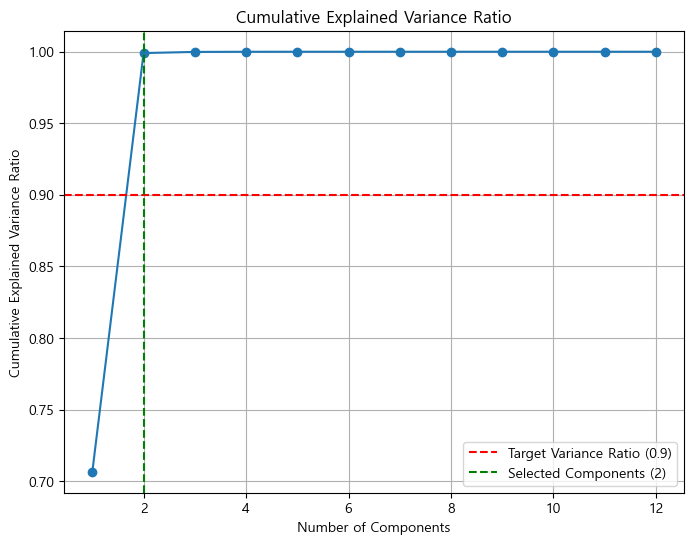

In [31]:
import matplotlib.pyplot as plt

# 누적 설명된 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

#n_components 값 시각하
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=target_variance_ratio, color='r', linestyle='--', label=f'Target Variance Ratio ({target_variance_ratio})')
plt.axvline(x=n_components, color='g', linestyle='--', label=f'Selected Components ({n_components})')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[low_num+high_num])
X_test_pca = pca.transform(X_test[low_num+high_num])

In [33]:
X_train['pca_component_1'] = X_train_pca[:, 0]
X_train['pca_component_2'] = X_train_pca[:, 1]

X_test['pca_component_1'] = X_test_pca[:, 0]
X_test['pca_component_2'] = X_test_pca[:, 1]

In [34]:
X_train.drop(columns = high_num + low_num)

,F08,F17,F21,F23,F28,F31,F35,F01,F02,F05,...,F25,F30,F34,F37,F39,F17_F31,F08_F28,F21_F23,pca_component_1,pca_component_2
0,6545602,3951843,892952,14292606,3305336,15734648,25287472,NSLHFNS,AVKQTCL,ISVXFVA,...,HLADEES,NZGEZLW,AXQFZWC,874810,2402,2316811,LPYPUNA_SMRBWMU,SWAZXZY_IDHAIQQ,-337.509212,-123.703426
1,2009250,1888355,9100506,14292606,2086019,15734648,25287472,VGIVWZQ,LSUSMVO,NFRVLWS,...,TPNEYOY,NZGEZLW,DRVVDHZ,511131,33575,846359,MIGYEEG_QVLCQTS,BUUUKVW_IDHAIQQ,-267.439416,-80.161479
2,1309718,3522486,5573998,2364926,2022187,5878143,25287472,JCDXFYU,PILDDJU,LFPUEOV,...,YMGUAHK,VHXETCF,QMOULXS,1114663,52515,682801,OFKQGTY_KGJACUM,FUZMWEL_ZXHXBZQ,2.586881,-117.166212
3,430401,3951843,778969,4790455,430401,15734648,25287472,PSMFWTP,ZYAVJHP,ATQPZSJ,...,IROGIOW,IVIRTPR,IZLJUJS,57875,4348,2316811,THBWWCD_UMIEGWH,BJAYVHN_VTYMMMX,-354.049945,-99.076069
4,2009250,3522486,4652049,400355,2086019,914797,25287472,SLCRICD,QPQWGXA,CHZGJZR,...,PWGXQTB,NZGEZLW,BHBIZCL,32121,8131,78943,MIGYEEG_YJFFIGH,LBABTIR_IZDGSXJ,384.900364,-88.714886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28605386,1057854,1679877,892952,14292606,2686863,15734648,25287472,NLVEHEJ,TQLUNHQ,TSAHWRE,...,ELRLVHO,TANUHHL,PNSISZF,874810,32889,825604,SODVHOK_SMRBWMU,SWAZXZY_IDHAIQQ,-190.544948,-120.447672
28605387,1382935,11421403,3171864,14292606,2686863,15734648,25287472,GGCUFPH,JLGELTR,MZOKJAS,...,OZQAFLN,FGOVFJM,AJHSFUP,243225,156356,6465391,IGQGIJM_BFVIKOK,YBGYGNW_IDHAIQQ,-357.059155,-99.131123
28605388,2014,3951843,892952,14292606,13429601,689897,25287472,SNXDPNU,VTPZTHN,ZTAHYDS,...,QIWQMAW,SLXYBBG,XIPYLHN,159800,46967,66922,CZDUWVM_FGQOGSD,SWAZXZY_IDHAIQQ,2.547464,-114.194422
28605389,11232542,3951843,4652049,14292606,13429601,15734648,25287472,RTCZYBD,FHCKUNS,EBCXZZE,...,VAJLQBS,YIXFVTW,KRVDSGK,745556,31298,2316811,FTPHMPQ_ZXLVSJX,LBABTIR_IDHAIQQ,392.329291,-108.540448


In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4538541 entries, 0 to 4538540
Data columns (total 39 columns):
 #   Column           Dtype  
---  ------           -----  
 0   F08              float64
 1   F17              int64  
 2   F21              int64  
 3   F23              float64
 4   F28              int64  
 5   F31              int64  
 6   F35              int64  
 7   F01              object 
 8   F02              object 
 9   F05              object 
 10  F07              object 
 11  F09              object 
 12  F10              object 
 13  F12              object 
 14  F13              float64
 15  F16              object 
 16  F22              float64
 17  F25              object 
 18  F30              object 
 19  F34              object 
 20  F37              float64
 21  F39              float64
 22  F14              float64
 23  F18              float64
 24  F19              float64
 25  F33              float64
 26  F38              float64
 27  F04         

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28605391 entries, 0 to 28605390
Data columns (total 39 columns):
 #   Column           Dtype  
---  ------           -----  
 0   F08              int64  
 1   F17              int64  
 2   F21              int64  
 3   F23              int64  
 4   F28              int64  
 5   F31              int64  
 6   F35              int64  
 7   F01              object 
 8   F02              object 
 9   F05              object 
 10  F07              object 
 11  F09              object 
 12  F10              object 
 13  F12              object 
 14  F13              int64  
 15  F16              object 
 16  F22              int64  
 17  F25              object 
 18  F30              object 
 19  F34              object 
 20  F37              int64  
 21  F39              int64  
 22  F14              float64
 23  F18              float64
 24  F19              float64
 25  F33              float64
 26  F38              float64
 27  F04       

In [37]:
# CatBoostEncoder 사용
enc1 = ce.CatBoostEncoder()
X_train[high_cat] = enc1.fit_transform(X_train[high_cat],train_y)
X_test[high_cat]= enc1.transform(X_test[high_cat])


In [38]:
'''
import category_encoders as ce
from sklearn.utils import resample

# 데이터 샘플링 (예: 10% 샘플링)
sample_fraction = 0.1
X_train_sampled, y_train_sampled = resample(X_train, train_y, n_samples=int(len(X_train) * sample_fraction), random_state=42)

# 고유 값 수 줄이기
for col in high_cat:
    if X_train_sampled[col].nunique() > 1000:  # 고유 값이 100개 이상인 경우
        top_values = X_train_sampled[col].value_counts().index[:1000]
        X_train_sampled[col] = X_train_sampled[col].apply(lambda x: x if x in top_values else 'other')
        X_test[col] = X_test[col].apply(lambda x: x if x in top_values else 'other')

# BinaryEncoder 사용
enc1 = ce.BinaryEncoder()
X_train_sampled_encoded = enc1.fit_transform(X_train_sampled[high_cat], y_train_sampled)
X_test_encoded = enc1.transform(X_test[high_cat])

X_train[high_cat] = enc1.transform(X_train[high_cat])
X_test[high_cat] = X_test_encoded
'''

"\nimport category_encoders as ce\nfrom sklearn.utils import resample\n\n# 데이터 샘플링 (예: 10% 샘플링)\nsample_fraction = 0.1\nX_train_sampled, y_train_sampled = resample(X_train, train_y, n_samples=int(len(X_train) * sample_fraction), random_state=42)\n\n# 고유 값 수 줄이기\nfor col in high_cat:\n    if X_train_sampled[col].nunique() > 1000:  # 고유 값이 100개 이상인 경우\n        top_values = X_train_sampled[col].value_counts().index[:1000]\n        X_train_sampled[col] = X_train_sampled[col].apply(lambda x: x if x in top_values else 'other')\n        X_test[col] = X_test[col].apply(lambda x: x if x in top_values else 'other')\n\n# BinaryEncoder 사용\nenc1 = ce.BinaryEncoder()\nX_train_sampled_encoded = enc1.fit_transform(X_train_sampled[high_cat], y_train_sampled)\nX_test_encoded = enc1.transform(X_test[high_cat])\n\nX_train[high_cat] = enc1.transform(X_train[high_cat])\nX_test[high_cat] = X_test_encoded\n"

In [39]:
'''
import optuna
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

def objective(trial, X_train_lgbm, y_train):
    # 하이퍼파라미터 값 튜닝 구간 지정
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    }
    
    X_train_lgbm, X_val_lgbm, y_train, y_val = train_test_split(X_train_lgbm, y_train, test_size=0.1, random_state=10)
    
    # 모델 생성 및 훈련
    model = LGBMClassifier(**param)
    model.fit(X_train_lgbm, y_train)

    # 예측 및 평가
    preds_proba = model.predict_proba(X_val_lgbm)[:, 1]  # 클래스 1의 확률을 사용하여 AUC를 계산
    auc = roc_auc_score(y_val, preds_proba)
    return auc

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, train_y), n_trials=30)

# 최적의 하이퍼파라미터 출력
best_params = study.best_trial.params
print("Best trial:", best_params)

# 최적성능 출력
best_score = study.best_value
print("Best score:", best_score)
'''

'\nimport optuna\nfrom lightgbm import LGBMClassifier\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import roc_auc_score\nimport numpy as np\n\ndef objective(trial, X_train_lgbm, y_train):\n    # 하이퍼파라미터 값 튜닝 구간 지정\n    param = {\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 300),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 20),\n        \'learning_rate\': trial.suggest_uniform(\'learning_rate\', 0.001, 0.1),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 1000),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 100),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.5, 1.0),\n        \'reg_alpha\': trial.suggest_loguniform(\'reg_alpha\', 1e-8, 10.0),\n        \'reg_lambda\': trial.suggest_loguniform(\'reg_lambda\', 1e-8, 10.0),\n    }\n    \n    X_train_lgbm, X_val_lgbm, y_train,

In [40]:
final_cat_model = CatBoostClassifier()
final_cat_model.fit(X_train, train_y)

Learning rate set to 0.5
0:	learn: 0.4994152	total: 6.66s	remaining: 1h 50m 49s
1:	learn: 0.4529101	total: 12.3s	remaining: 1h 42m 3s
2:	learn: 0.4397105	total: 15.8s	remaining: 1h 27m 39s
3:	learn: 0.4349001	total: 18.5s	remaining: 1h 16m 57s
4:	learn: 0.4323732	total: 21.3s	remaining: 1h 10m 40s
5:	learn: 0.4309796	total: 24.1s	remaining: 1h 6m 25s
6:	learn: 0.4300079	total: 26.8s	remaining: 1h 3m 26s
7:	learn: 0.4294258	total: 29.3s	remaining: 1h 28s
8:	learn: 0.4287044	total: 31.7s	remaining: 58m 9s
9:	learn: 0.4281113	total: 34.7s	remaining: 57m 13s
10:	learn: 0.4276070	total: 37.5s	remaining: 56m 8s
11:	learn: 0.4272905	total: 40s	remaining: 54m 49s
12:	learn: 0.4269624	total: 42.3s	remaining: 53m 32s
13:	learn: 0.4265807	total: 44.8s	remaining: 52m 36s
14:	learn: 0.4262318	total: 47.4s	remaining: 51m 54s
15:	learn: 0.4258270	total: 50.3s	remaining: 51m 35s
16:	learn: 0.4255271	total: 52.9s	remaining: 51m
17:	learn: 0.4252322	total: 55.4s	remaining: 50m 21s
18:	learn: 0.4249755	t

In [41]:
final_cat_pred = final_cat_model.predict_proba(X_test)

In [42]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,Click
0,TEST_0000000,0
1,TEST_0000001,0
2,TEST_0000002,0
3,TEST_0000003,0
4,TEST_0000004,0
...,...,...
4538536,TEST_4538536,0
4538537,TEST_4538537,0
4538538,TEST_4538538,0
4538539,TEST_4538539,0


In [43]:
sample_submission['Click'] = final_cat_pred[:,1]
sample_submission

,ID,Click
0,TEST_0000000,0.211244
1,TEST_0000001,0.120087
2,TEST_0000002,0.109995
3,TEST_0000003,0.369154
4,TEST_0000004,0.363374
...,...,...
4538536,TEST_4538536,0.283011
4538537,TEST_4538537,0.142272
4538538,TEST_4538538,0.042509
4538539,TEST_4538539,0.448949


In [44]:
sample_submission.to_csv('submission8.csv', index=False)

---------------------------------

feature importance를 확인하는 코드

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)  
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances


### Model Train and Inference

### Submission

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,Click
0,TEST_0000000,0
1,TEST_0000001,0
2,TEST_0000002,0
3,TEST_0000003,0
4,TEST_0000004,0
...,...,...
4538536,TEST_4538536,0
4538537,TEST_4538537,0
4538538,TEST_4538538,0
4538539,TEST_4538539,0


In [ ]:
sample_submission['Click'] = final_preds_proba[:,1]
sample_submission

,ID,Click
0,TEST_0000000,0.237218
1,TEST_0000001,0.132361
2,TEST_0000002,0.131566
3,TEST_0000003,0.352874
4,TEST_0000004,0.360681
...,...,...
4538536,TEST_4538536,0.240288
4538537,TEST_4538537,0.176537
4538538,TEST_4538538,0.036927
4538539,TEST_4538539,0.443488


In [ ]:
sample_submission.to_csv('submission7.csv', index=False)